# 互评作业1：探索性分析与预处理（2/2）

运行此notebook需要matplotlib库。

本次互评作业使用的两个数据集是：1) Wine Reviews；2）Oakland Crime Statistics 2011-2016。下面展示对于第二个数据集Oakland Crime Statistics 2011-2016的预处理过程，第一个数据集Wine Reviews的预处理在另一个文件之中。

在开始处理之前，先导入在前一个文件中已经定义过的各种处理方法。这些方法在文件1中都有用到，此处不过多做介绍。

In [1]:
import json
import csv
import matplotlib.pyplot as plt
from collections import defaultdict

# 五数概括和缺失值计数
def fivenum_summary(vals):
    '''输入一组数据，依次返回这组数据的最小值、下四分位点、中位数、上四分位点、最大值，即从小到大排序的五个概括数。
    返回的数据都是取自输入的数据，不会进行数学运算。'''
    srted = sorted(vals)
    count = len(vals)
    vmax = srted[-1]
    vmin = srted[0]
    vmid = srted[count // 2]
    vquadlow = srted[count // 4]
    vquadhigh = srted[count*3 // 4]
    return (vmin, vquadlow, vmid, vquadhigh, vmax)

def missing_count(data, columnNo):
    '''输入数据以及所统计的列，返回这一列缺失多少值。'''
    cnt = 0
    for d in data:
        if d[columnNo] == '':
            cnt += 1
    return cnt

# 对标称值计数以及画条形图
def count_occurence(data,column,ignore_empty=True):
    '''统计数据某个特定列中所有元素的出现次数，返回一个dict-like
    如果置ignore-empty为True，则返回的字典中不包含空值的计数'''
    count = defaultdict(int)
    for row in data:
        if ignore_empty and row[column]=='':
            continue
        count[row[column]]+=1
    return count
def cutoff(datadict,ratio,total_amt=None,return_ratio=True):
    '''返回一个经过截断的字典，只保留占总数大于等于一定比例的条目。
    参数return_tario表示返回字典的值使用绝对值（False）还是比例（True）'''
    if total_amt == None: # 如果没有给总体数量，就用输入数据之和代替
        total_amt = sum(datadict.values())
    ret = {}
    for key in datadict:
        val = datadict[key]
        percent = val/total_amt
        if percent>=ratio:
            ret[key]=percent*100 if return_ratio else val
    return ret
def plot_barchart(title,Xlabel,Ylabel,data,do_sort=False,bar_width=0.4,figsize=None):
    plt.figure(title,figsize=figsize)
    plt.title(title)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    count = len(data) # 有几个bars要画
    keys = list(data.keys())
    if do_sort:
        keys.sort(key=lambda k:data[k],reverse=True)
    for i,name in enumerate(keys):
        plt.bar(
            i,# 横向位置
            data[name], #数据
            width = bar_width, # 宽度
            # 边缘
            ec='k',lw=1
        )
    plt.xticks([i for i in range(count)],[(key if key !='' else '(missing)') for key in keys])
    plt.show()

## 数据集2：Oakland Crime Stats '11-'16

[Oakland Crime Statistics 2011 to 2016](https://www.kaggle.com/cityofoakland/oakland-crime-statistics-2011-to-2016)是加州奥克兰市政府维护的关于警察局出警事件的数据集，每日一更，包含记录的创建日期、编号、类型、地址、所在区域、事件类型等信息。

数据集中包含6个csv文件，每年一个。每一个csv文件均附有一个存储元数据的json文件。我们读取每一个csv文件，并查看有哪些列：

In [2]:
def read_csv(filename):
    with open(filename) as f:
        csv_content = csv.reader(f)
        columns = next(csv_content)
        rows = [row for row in csv_content]
    return columns, rows

cols={}
rows={}
for year in range(2011,2017):
    cols[year], rows[year] = read_csv(f'Oakland Crime Statistics/records-for-{year}.csv')
    print(year,end=':')
    print(cols[year])

2011:['Agency', 'Create Time', 'Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time']
2012:['Agency', 'Create Time', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time', 'Location 1', 'Zip Codes']
2013:['Agency', 'Create Time', 'Location ', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time']
2014:['Agency', 'Create Time', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time', 'Location 1', 'Zip Codes']
2015:['Agency', 'Create Time', 'Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time']
2016:['Agency', 'Create Time', 'Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time']


可以看出12年和14年的记录格式与其他年份不完全相同。我们对其进行一点处理，从而合并成统一的文件。

观察这些列，12年和14年仅仅是将地址放在了最后，并附加了邮编信息。由于邮编信息只有这两年的数据有，所以我们忽略之。而地址信息，实际上这两年和其他年份的存储方式也是不同的：

In [3]:
print(rows[2012][0][9]) # 12年第一条记录的地址
print(rows[2014][0][9]) # 14年第一条记录的地址
print(rows[2011][0][2]) # 11年第一条记录的地址

{'human_address': '{"address": "OLIVE ST", "city": "", "state": "", "zip": ""}'}
{'human_address': '{"address": "LINDEN ST", "city": "", "state": "", "zip": ""}'}
 ST&SAN PABLO AV


可以看出，12和14年的`Location 1`字段其实是一段类似JSON的文本，其中`human_address.address`项对应着其他年份存储的地址信息。我们使用这一部分信息。

接下来，我们对数据进行合并。

In [4]:
def addr1toaddr(s):
    # 外层部分不是json，需要先做一些替换工作
    # 实际上可以直接使用eval()获取值，但考虑安全因素不采用
    if s=='': return ''
    s2 = s.replace('"',"\\'").replace("'",'"')
    return json.loads(json.loads(s2)['human_address'])['address']

columns = ['Year']+cols[2011]
print('总体数据的各列:',end='')
print(columns)

records = []
record_count = 0
for year in [2011,2013,2015,2016]:
    for record in rows[year]:
        records.append([year]+record)
        assert len(records[-1]) == 11
        record_count+=1
for year in [2012,2014]:
    for record in rows[year]:
        addr_json = record[9]
        
        records.append(
            [year]+
            record[0:2]+
            [addr1toaddr(record[9])]+
            record[2:9]
        )
        assert len(records[-1])==11
        record_count += 1
records.sort(key=lambda rec:rec[0])
print(f"记录条数: {record_count}")

总体数据的各列:['Year', 'Agency', 'Create Time', 'Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Closed Time']
记录条数: 1046388


现在总体数据是按年份排序的，除此之外的顺序仍按照原数据的顺序。

## 数值型数据的分析和补全

### 数据摘要

该数据集中没有纯数值的数据，除两个时间点数据Create Time和Closed Time外，其余都是标称型或者字符串。但是，我们仍然可以计算出事件的持续时间（Closed-Create）。下面是对持续时间的分析。

时间持续时间（小时数）的五数概括: (0.0, 0.38333333333333336, 1.106111111111111, 2.618611111111111, 23.99972222222222)


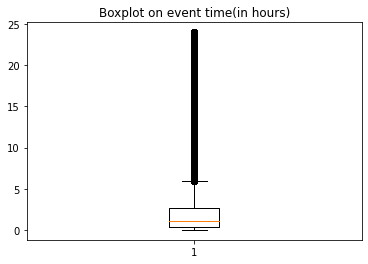

In [5]:
import datetime
event_hours = []
for record in records:
    if record[2]=='' or record[-1]=='':
        continue
    begin = datetime.datetime.fromisoformat(record[2])
    end = datetime.datetime.fromisoformat(record[-1])
    event_hours.append((end-begin).seconds / 3600)
print("时间持续时间（小时数）的五数概括: ",end='')
print(fivenum_summary(event_hours))
plt.figure()
plt.title("Boxplot on event time(in hours)")
plt.boxplot(event_hours)
plt.show()

如图所示，绝大多数事件都能在5小时内close掉，但是存在大量离群点：

In [6]:
fivenum = fivenum_summary(event_hours)
iqr = fivenum[3]-fivenum[1]
q1 = fivenum[1]
q3 = fivenum[3]
iqr = q3-q1
outliers = [i for i in event_hours if ((i<q1-1.5*iqr) or (i>q3+1.5*iqr))]
len(outliers) # 离群点个数

95997

9.6k个离群点约占整体的9.2%，还是很多的。我们接下来统计起止时间至少缺一个的数据：

In [7]:
time_missing = [record for record in records if '' in (record[2],record[-1])]
len(time_missing)

29

### 缺失值分析

接下来我们分析这些缺失值。我们将这些残缺的起止时间打印出来：

In [8]:
for record in time_missing:
    print(f'{record[2]:24} - {record[-1]:24}')

2011-11-05T23:50:42.000  -                         
2011-11-06T00:51:23.000  -                         
2011-11-06T01:23:47.000  -                         
2011-11-06T01:34:32.000  -                         
2011-11-06T01:36:53.000  -                         
2011-11-06T01:56:45.000  -                         
                         -                         
2012-11-03T20:24:24.000  -                         
2012-11-03T21:35:29.000  -                         
2012-11-03T22:09:33.000  -                         
2012-11-03T22:16:19.000  -                         
2012-11-03T22:47:53.000  -                         
2012-11-03T22:49:09.000  -                         
2012-11-03T23:22:39.000  -                         
2012-11-03T23:29:48.000  -                         
2012-11-04T00:18:30.000  -                         
2012-11-04T00:25:17.000  -                         
2012-11-04T00:25:18.000  -                         
2012-11-04T00:31:03.000  -                         
2012-11-04T0

发现除了起止时间皆无的数据，其余数据都集中在几个特定时段：11年11月5日23:50至次日02:00、12年11月3日20:24至次日01:30，以及13年8月31日03:21:24。

起止时间皆无的数据只能丢弃。而仅有开始时间没有关闭时间的事件，可以丢弃或进行数据补全。之前持续时间的统计中已经丢弃了缺失信息的数据，这部分数据占比很小，对于其分布基本上没有影响。这里使用持续时间的平均值做数据补全，并展示补全后的数据。

In [9]:
avg_hrs = sum(event_hours)/len(event_hours)
time_filled = []
for record in time_missing:
    if record[2]=='': continue
    begin_dt = datetime.datetime.fromisoformat(record[2])
    end_dt = begin_dt + datetime.timedelta(hours=avg_hrs)
    time_filled.append((record[2],end_dt.isoformat()))
    print(f'{record[2]:24} - {time_filled[-1][1]:24}')

2011-11-05T23:50:42.000  - 2011-11-06T02:06:15.135206
2011-11-06T00:51:23.000  - 2011-11-06T03:06:56.135206
2011-11-06T01:23:47.000  - 2011-11-06T03:39:20.135206
2011-11-06T01:34:32.000  - 2011-11-06T03:50:05.135206
2011-11-06T01:36:53.000  - 2011-11-06T03:52:26.135206
2011-11-06T01:56:45.000  - 2011-11-06T04:12:18.135206
2012-11-03T20:24:24.000  - 2012-11-03T22:39:57.135206
2012-11-03T21:35:29.000  - 2012-11-03T23:51:02.135206
2012-11-03T22:09:33.000  - 2012-11-04T00:25:06.135206
2012-11-03T22:16:19.000  - 2012-11-04T00:31:52.135206
2012-11-03T22:47:53.000  - 2012-11-04T01:03:26.135206
2012-11-03T22:49:09.000  - 2012-11-04T01:04:42.135206
2012-11-03T23:22:39.000  - 2012-11-04T01:38:12.135206
2012-11-03T23:29:48.000  - 2012-11-04T01:45:21.135206
2012-11-04T00:18:30.000  - 2012-11-04T02:34:03.135206
2012-11-04T00:25:17.000  - 2012-11-04T02:40:50.135206
2012-11-04T00:25:18.000  - 2012-11-04T02:40:51.135206
2012-11-04T00:31:03.000  - 2012-11-04T02:46:36.135206
2012-11-04T00:32:53.000  - 2

## 标称型数据的分析和补全

接下来我们对所有标称值的属性做分析，包含下列属性：

- `Year`（由于涉及的年份只有5年，因此可以当做标称型）
- `Agency`
- `Area ID`
- `Beat`
- `Priority`
- `Incident Type Id`和`Incident Type Description`

### Agency属性

对Agency属性不需要做过多分析，因为该属性只有一个可能的非空值`OP`，含义应该为奥克兰市警察局。

In [10]:
agencies=defaultdict(int)
for record in records:
    agencies[record[1]]+=1
agencies

defaultdict(int, {'OP': 1046384, '': 4})

因此，缺失的四条数据也应该补“OP”。此处展示缺失这项属性的数据。

In [11]:
for record in records:
    if record[1]=='':
        print(record)

[2011, '', '', '   ', '', '', '', '', '', '', '']
[2012, '', '', '', '', '', '', '', '', '', '']
[2013, '', '', '      ', '', '', '', '', '', '', '']
[2016, '', '', '      ', '', '', '', '', '', '', '']


不过看上去这些数据都是空记录，应当删去之。这4条记录刚好对应上文起止时间皆无的记录。

我们更新整体的数据集，删去这几条空白数据。需要指出，这一操作不会影响上面对数据的分析，因为之前的分析，除了补全部分将其特意忽略外没有涉及到这些数据。

In [12]:
records_clean=[record for record in records if record[1]!='']
records_clean_count = len(records_clean)

### Year属性

这条属性是我们自己设置的属性，没有缺失。我们画出这个属性的条形图：

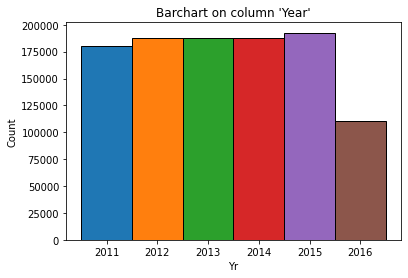

In [13]:
yr_count={}
for yr in rows:
    # 考虑到上面的清理工作，11、12、13、16这四年的数量应当-1。这里全减了，之后加回来
    yr_count[yr]=len(rows[yr])-1
yr_count[2014]+=1
yr_count[2015]+=1
plot_barchart("Barchart on column 'Year'","Yr","Count",yr_count,bar_width=1.0)

16年的记录明显较其他年份少，可能的原因是16年的记录不完整。我们看一下16年最后一条记录的发生时间：

In [14]:
max([record[2] for record in records_clean if record[0]==2016])

'2016-07-31T23:57:31.000'

这就表明16年的数据只记录到7月，8-12月的记录是缺失的。为了检验1-7月的数据是否也有大量缺失，我们检验一下记录的比例：

In [15]:
(yr_count[2016]/yr_count[2015], 7/12)

(0.575482524236555, 0.5833333333333334)

考虑了16年仅记录到7月底的因素后，16年的记录密度较15年只有2%左右的差距，考虑到数据自身的波动性，可以认为1-7月的数据应当是不存在大规模的缺失情况的。

### Area ID

先统计缺失值数量和分布情况。

缺失值数量: 182361


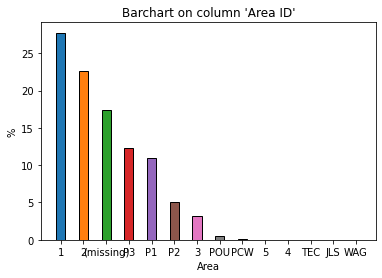

In [16]:
areaid_cnt = count_occurence(records_clean,4,False)
print(f'缺失值数量: {areaid_cnt[""]}')
plot_barchart("Barchart on column 'Area ID'","Area",'%',cutoff(areaid_cnt,.0),do_sort=True)

缺失值非常多，有很多记录很少的区域，同时我们也注意到了可能存在两种不同的值域：或许1、2、3和P1、P2、P3是同一个区域。我们分年份重新进行统计：

2011年：
缺失值数量: 903


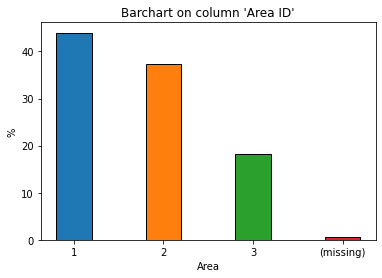

2012年：
缺失值数量: 1414


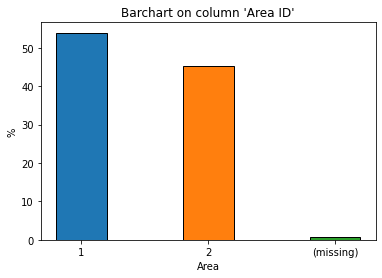

2013年：
缺失值数量: 2257


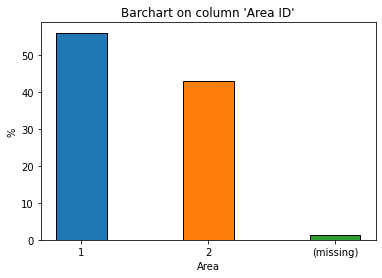

2014年：
缺失值数量: 177787


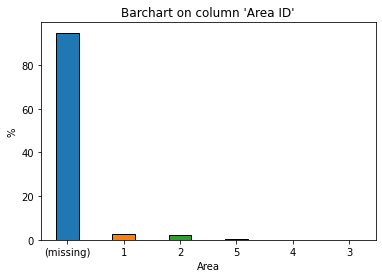

2015年：
缺失值数量: 0


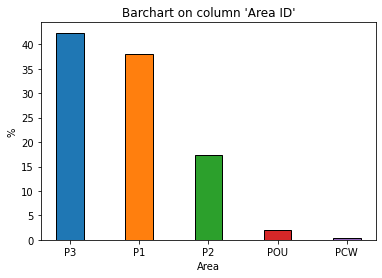

2016年：
缺失值数量: 0


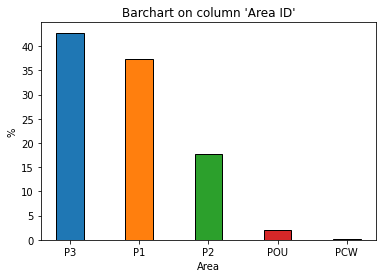

In [17]:
for year in range(2011,2017):
    print(f"{year}年：")
    records_filter=[record for record in records_clean if record[0]==year]
    areaid_cnt = count_occurence(records_filter,4,False)
    print(f'缺失值数量: {areaid_cnt[""]}')
    plot_barchart("Barchart on column 'Area ID'","Area",'%',cutoff(areaid_cnt,.001),do_sort=True)

主要的缺失值来自2014年，这一年80%以上的记录都是不含Area ID的。同时我们注意到，每一年的区域ID都不尽相同，数量和名称都不匹配。有几种可能的原因：Area ID表示的行政区划每年都在变动，或在不同的数据集中Area ID本身就含有不同的意义。

缺失值处理。15-16两年没有缺失值，而14年缺失值占比较大，因此只考虑11-13三年的缺失值处理。

先看2011年。由于Area可以通过地址来确定，虽然我们不能有效利用字符串型的地址字段，但是可以使用Beat（管区）字段，我们先来看一下这些数据中有多少是提供了管区信息的：

In [18]:
records_2011 = list(filter(lambda record:record[0]==2011,records_clean))
len([None for record in records_2011 if record[4]=='' and record[5]!=''])

719

于是我们可以用管区来推出Area。我们先统计每个管区应该属于哪一个Area，方法是统计管区和Area同时存在的次数：

In [19]:
beat_area_cnt = defaultdict(lambda:defaultdict(int))
for record in records_2011:
    if record[5]=='':continue # Beat缺失
    if record[4]=='':continue # Area缺失
    beat_area_cnt[record[5]][record[4]]+=1
for beat in beat_area_cnt:
    print(beat,end='\t')
    print(dict(beat_area_cnt[beat]))

06X	{'1': 5098}
07X	{'1': 4114, '2': 1}
10Y	{'1': 2371}
21Y	{'2': 3425, '1': 2}
20X	{'2': 4260, '1': 7}
08X	{'1': 6875, '2': 1, '3': 1}
33X	{'3': 2019, '2': 1800, '1': 1}
24X	{'2': 2445, '1': 1}
26Y	{'3': 2857, '2': 2593}
10X	{'1': 2956, '3': 1}
34X	{'3': 2480, '2': 2164}
28X	{'3': 1186, '2': 988}
32Y	{'3': 1581, '2': 1525}
19X	{'2': 2505, '1': 2440}
30X	{'3': 2599, '1': 3, '2': 2327}
22Y	{'2': 1319, '3': 1, '1': 1338}
02Y	{'1': 2958}
12Y	{'1': 2646}
04X	{'1': 7398, '2': 1, '3': 1}
03X	{'1': 3807, '2': 1}
03Y	{'1': 2712, '2': 7, '3': 2}
17Y	{'2': 1296, '3': 5, '1': 1275}
26X	{'3': 1598, '2': 1369}
32X	{'3': 1875, '2': 1821}
25X	{'2': 2083, '1': 1926}
24Y	{'2': 2566, '3': 1}
12X	{'1': 2416, '2': 1}
35X	{'3': 1901, '1': 1, '2': 1957}
02X	{'1': 2609, '2': 1}
31Y	{'3': 2115, '2': 1938, '1': 1}
22X	{'2': 1515, '1': 1534}
05X	{'1': 2619}
01X	{'1': 2201, '2': 2}
16Y	{'2': 767, '1': 787}
18Y	{'2': 958, '3': 1, '1': 813}
09X	{'1': 3619, '2': 2}
30Y	{'3': 2726, '2': 2538, '1': 1}
27Y	{'3': 2207,

虽然存在一定数量的特殊情况，但是管区还是大致能对应到Area的。因此我们使用每个管区命中次数最多的Area来填充缺失的Area；12、13两年的数据也照此办理。

填充数据中的Area ID计数(2011年): defaultdict(<class 'int'>, {'2': 189, '3': 318, '1': 212})


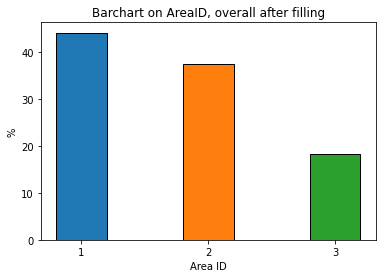

In [20]:
beat_pred={}
for beat in beat_area_cnt:
    beat_pred[beat] = max(beat_area_cnt[beat],key=lambda k:beat_area_cnt[beat][k])
area_filled = []
area_exist=[]
for record in records_2011:
    if record[4]!='':
        area_exist.append([record[4]])
    elif record[5]!='':
        area_filled.append([beat_pred[record[5]]])
print('填充数据中的Area ID计数(2011年): ',end='')
print(count_occurence(area_filled,0,True))
plot_barchart(
    'Barchart on AreaID, overall after filling',
    'Area ID', '%',
    cutoff(count_occurence(area_filled+area_exist,0),.0),
    do_sort = True
)

可以说，这些缺失数据对整体分布的影响是比较小的。

对于2012年的数据，处理结果如下：

填充数据中的Area ID计数(2012年): defaultdict(<class 'int'>, {'1': 519, '2': 702})


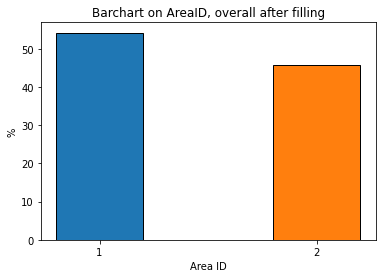

In [21]:
records_2012 = list(filter(lambda record:record[0]==2012,records_clean))
beat_area_cnt = defaultdict(lambda:defaultdict(int))
for record in records_2012:
    if record[5]=='':continue # Beat缺失
    if record[4]=='':continue # Area缺失
    beat_area_cnt[record[5]][record[4]]+=1
beat_pred={}
for beat in beat_area_cnt:
    beat_pred[beat] = max(beat_area_cnt[beat],key=lambda k:beat_area_cnt[beat][k])
area_filled = []
area_exist=[]
for record in records_2012:
    if record[4]!='':
        area_exist.append([record[4]])
    elif record[5]!='':
        area_filled.append([beat_pred[record[5]]])
print('填充数据中的Area ID计数(2012年): ',end='')
print(count_occurence(area_filled,0,True))
plot_barchart(
    'Barchart on AreaID, overall after filling',
    'Area ID', '%',
    cutoff(count_occurence(area_filled+area_exist,0),.0),
    do_sort = True
)

对于2013年的数据，处理结果如下：

填充数据中的Area ID计数(2013年): defaultdict(<class 'int'>, {'1': 519, '2': 702})


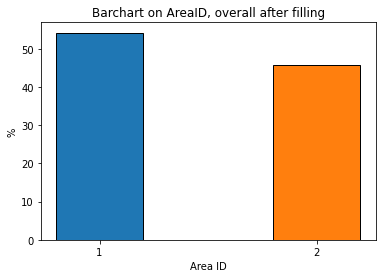

In [22]:
records_2013 = list(filter(lambda record:record[0]==2012,records_clean))
beat_area_cnt = defaultdict(lambda:defaultdict(int))
for record in records_2013:
    if record[5]=='':continue # Beat缺失
    if record[4]=='':continue # Area缺失
    beat_area_cnt[record[5]][record[4]]+=1
beat_pred={}
for beat in beat_area_cnt:
    beat_pred[beat] = max(beat_area_cnt[beat],key=lambda k:beat_area_cnt[beat][k])
area_filled = []
area_exist=[]
for record in records_2013:
    if record[4]!='':
        area_exist.append([record[4]])
    elif record[5]!='':
        area_filled.append([beat_pred[record[5]]])
print('填充数据中的Area ID计数(2013年): ',end='')
print(count_occurence(area_filled,0,True))
plot_barchart(
    'Barchart on AreaID, overall after filling',
    'Area ID', '%',
    cutoff(count_occurence(area_filled+area_exist,0),.0),
    do_sort = True
)

### Beat

与之前的Area类似，我们先整体分析其缺失值状况和总体分布情况：

缺失值数量: 5801


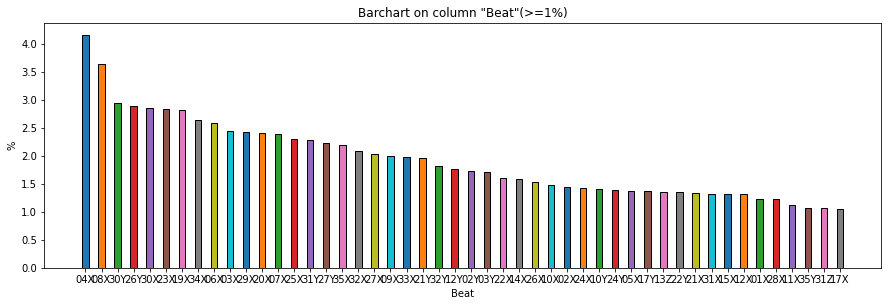

In [23]:
beat_count = count_occurence(records_clean,5,False)
print(f'缺失值数量: {beat_count[""]}')
plot_barchart(
    'Barchart on column "Beat"(>=1%)',
    "Beat",'%',
    cutoff(beat_count,.01),
    do_sort=True,
    figsize=(15,4.5)
)

可见Beat方面，出警记录分布在大多数管区中，但是一些管区（如04X、08X等）的出警记录密度较其他管区高。对于缺失值的处理，首先考虑直接忽略这些缺失值。忽略缺失值之后，剩余数据的分布情况如下所示。

年份上的分布情况：

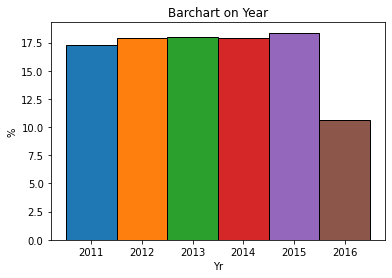

In [24]:
records_beatfilter = [record for record in records if record[5]!='']
plot_barchart(
    'Barchart on Year',
    'Yr','%',
    cutoff(count_occurence(records_beatfilter,0),0.),
    bar_width = 1.0
)

可见被删除数据以14、15两年为主。

持续时间的分布情况。由于缺失数据比例较低，所以仅展示缺失数据时间上的分布情况。

(0.0, 0.013888888888888888, 0.08944444444444444, 0.5052777777777778, 23.99972222222222)


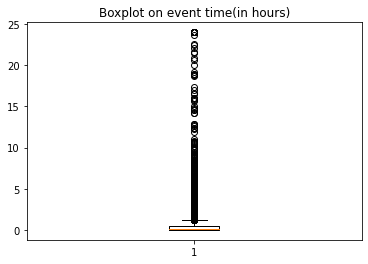

In [25]:
times_filtered = [(record[2],record[-1]) for record in records if record[5]=='']
hrs = []
for sbegin,send in times_filtered:
    if '' in (sbegin,send):continue
    delta = datetime.datetime.fromisoformat(send)-datetime.datetime.fromisoformat(sbegin)
    hrs.append(delta.seconds/3600)
print(fivenum_summary(hrs))
plt.figure()
plt.title("Boxplot on event time(in hours)")
plt.boxplot(hrs)
plt.show()

可见，这些没有指明管区的时间绝大多数是半小时内结束的短事件。由于管区信息分布的较为平均，没有明显处于主要地位的取值，因此并不用最常用值来填充这些缺失值。

### Priority

首先统计这个属性的缺失值情况和分布情况。

缺失值数量: 0


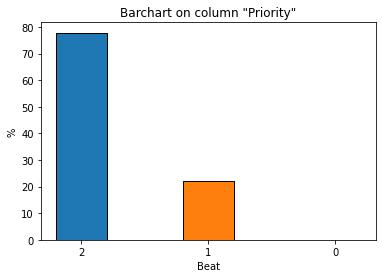

事件优先级统计表
等级	次数
1	231542
2	814818
0	24


In [26]:
pri_count = count_occurence(records_clean,6,False)
print(f'缺失值数量: {pri_count[""]}')
_=pri_count.pop('')
plot_barchart(
    'Barchart on column "Priority"',
    "Beat",'%',
    cutoff(pri_count,.0),
    do_sort=True
)
print("事件优先级统计表")
print("等级\t次数")
for pri in pri_count:
    print(f'{pri}\t{pri_count[pri]}')

可见从优先级来看，应当是0级事件最重要，2级事件最不重要。稍后分析事件类型时我们将会分析何种事件对应什么样的优先级。

我们现在对优先级和处理时间的关联进行分析。我们按优先级对事件分类，之后分别绘制处理时间的盒图：

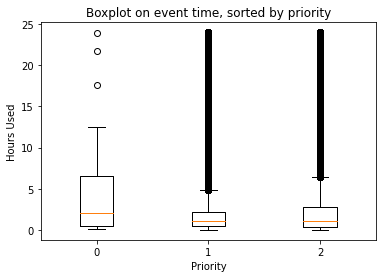

In [27]:
hrs = [[],[],[]]
for record in records_clean:
    sbegin = record[2]
    send = record[-1]
    if '' in (sbegin,send):continue
    delta = datetime.datetime.fromisoformat(send)-datetime.datetime.fromisoformat(sbegin)
    hrs[int(record[6])].append(delta.seconds/3600)
plt.figure()
plt.title('Boxplot on event time, sorted by priority')
plt.xlabel('Priority')
plt.ylabel('Hours Used')
plt.boxplot(hrs,positions=range(3))
plt.show()

图中可见，优先级0事件的处理用时比另两个优先级长。虽然离群值的绝对数量较少，但考虑到优先级0的事件本身就比另两类事件少4个数量级，这也表示优先级0的事件执行时间有可能更高。优先级1事件的处理时间较优先级2为短。

### Incident Type

事件类别和其后的解释说明在逻辑上应当存在一致关系，在此统一处理。

我们先看事件类别的缺失值和分布情况，再看类别解释说明的缺失值和分布情况。由于解释说明比较长，画图时会叠在一起，所以另附统计表。

事件类别ID缺失值数量: 0
类别ID可能取值有288种


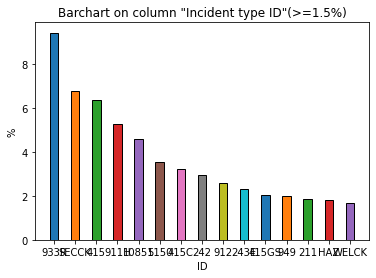

事件类别说明缺失值数量: 388
类别说明可能取值有288种


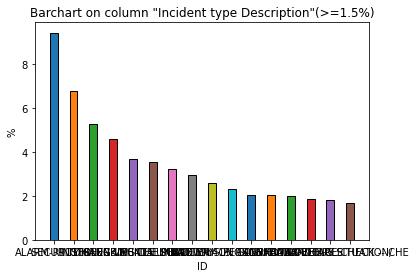

事件优先级统计表
次数	说明
98497	ALARM-RINGER
70965	SECURITY CHECK
54935	911 HANG-UP
47958	STOLEN VEHICLE
38257	DISTURBING THE PEACE
37218	MENTALLY ILL
33470	415 UNKNOWN
30636	BATTERY
26984	SUSPICIOUS PERSON
23964	BATTERY ON CO-HABITA
21520	415 GUNSHOTS
21372	415 FAMILY
20781	SUSPICIOUS VEHICLE
19452	ROBBERY
18948	HAZARDOUS SITUATION/
17450	WELFARE CHECK -- CHE


In [28]:
typeid_count = count_occurence(records_clean,7,False)
print(f'事件类别ID缺失值数量: {typeid_count[""]}')
print(f'类别ID可能取值有{len(typeid_count)-1}种') # -1是因为还有一个空字符串
#_=typeid_count.pop('')
plot_barchart(
    'Barchart on column "Incident type ID"(>=1.5%)',
    "ID",'%',
    cutoff(typeid_count,.015),
    do_sort=True
)

typedesp_count = count_occurence(records_clean,8,False)
print(f'事件类别说明缺失值数量: {typedesp_count[""]}')
print(f'类别说明可能取值有{len(typedesp_count)-1}种') # -1是因为还有一个空字符串
#_=typedesp_count.pop('')
plot_barchart(
    'Barchart on column "Incident type Description"(>=1.5%)',
    "ID",'%',
    cutoff(typedesp_count,.015),
    do_sort=True
)
desps = list(typedesp_count.keys())
desps.sort(key = lambda d:typedesp_count[d],reverse=True)
print("事件优先级统计表")
print("次数\t说明")
for desp in desps:
    if typedesp_count[desp] <= .015*records_clean_count:
        break
    print(f'{typedesp_count[desp]}\t{desp}')

考察类别ID与Description的对应关系：

In [29]:
desc_collect = defaultdict(set)
for record in records_clean:
    desc_collect[record[7]].add(record[8])
# 删去空字符串
for eid in desc_collect:
    desc_collect[eid].add('')
    desc_collect[eid].remove('')

desc_count = {}
for eid in desc_collect:
    desc_count[eid] = len(desc_collect[eid])
    
print("No description: ")
print('#occurs\tID')
for eid in desc_collect:
    if desc_count[eid]==0:
        print(f'{typeid_count[eid]}\t{eid}')
print()
        
print('Multiple descriptions:')
for eid in desc_collect:
    if desc_count[eid]>1:
        print(f'{eid} ({typeid_count[eid]} occurs)')
        for desc in desc_collect[eid]:
            print('\t'+desc)

No description: 
#occurs	ID
388	JGP

Multiple descriptions:
415 (66720 occurs)
	415 FAMILY
	DISTURBING THE PEACE
	DISTURBANCE-DRINKERS
647 (4763 occurs)
	DISORDERLY CONDUCT
	DISORDERLY CONDUCT:
901 (8156 occurs)
	VEHICLE COLLISION-DR
	VEHICLE COLLISION/PR
955 (6590 occurs)
	ANIMAL-STRAYING
	INJURIED ANIMAL


除了一个ID为JGP的事件从未见到描述以外，其余事件都有对应的描述，且大多数具有唯一的描述。有4个事件ID具有多个描述，这些描述表达的意思是大致相同的，因此可以随机使用其一来补全缺失数据。

In [30]:
records_filled = []
for record in records_clean:
    new_rec = record.copy()
    if record[8]=='':
        if desc_count[record[7]]==0:
            new_rec[8]=record[7]
        else:
            new_rec[8]=desc_collect[record[7]]
            desc_collect.add(new_rec[8])
        records_filled.append(new_rec)
len(records_filled)

388

最后，我们看一下不同优先级的事件中，事件类型的分布。

Priority 0:
%	ID	Description
87.50	940B	OFFICER NEEDS IMMEDI
12.50	REDALT	RED ALERT-AIRPLANE I


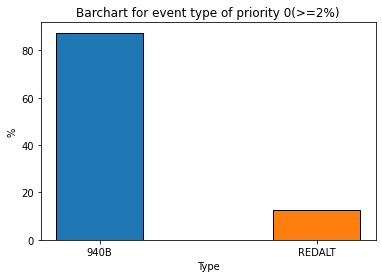

Priority 1:
%	ID	Description
10.76	242	BATTERY
8.83	243E	BATTERY ON CO-HABITA
7.04	211	ROBBERY
5.84	901A	VEHICLE COLLISION-PE
5.11	943	FIGHT
4.82	245	ASSAULT W/DEADLY WEA
4.31	CODE7	SUBJECT ARMED WITH W
3.34	459	BURGLARY
2.79	5150	MENTALLY ILL
2.47	929	FIRE
2.44	459AU	AUTO BURGLARY--IP
2.25	918	PERSON SCREAMING
2.16	415C	415 UNKNOWN
2.11	415	415 FAMILY


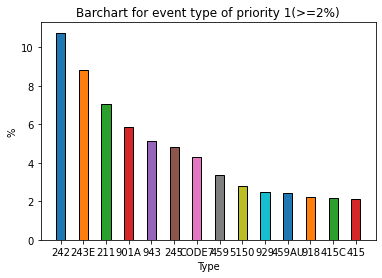

Priority 2:
%	ID	Description
11.84	933R	ALARM-RINGER
8.53	SECCK	SECURITY CHECK
7.59	415	415 FAMILY
6.74	911H	911 HANG-UP
5.64	10851	STOLEN VEHICLE
3.78	5150	MENTALLY ILL
3.49	415C	415 UNKNOWN
3.13	912	SUSPICIOUS PERSON
2.51	949	SUSPICIOUS VEHICLE
2.23	415GS	415 GUNSHOTS
2.07	HAZ	HAZARDOUS SITUATION/


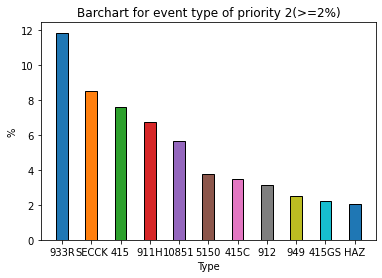

In [31]:
types = [[],[],[]]

for record in records_clean:
    types[int(record[6])].append([record[7]])

r=.02
for priority in range(3):
    print(f"Priority {priority}:")
    stats = cutoff(count_occurence(types[priority],0),r)
    stats_keys = sorted(stats.keys(),key=lambda s:stats[s],reverse=True)
    print("%\tID\tDescription")
    for eid in stats_keys:
        if stats[eid]<r:break
        print(f"{stats[eid]:.2f}",end='\t')
        print(eid,end='\t')
        print(list(desc_collect[eid])[0])
    plot_barchart(
        f"Barchart for event type of priority {priority}(>=2%)",
        'Type',
        '%',
        stats,
        do_sort=True
    )

从上述分析可以大致确定不同优先级对应的主要事件类型。优先级0的事件类型只有两类紧急的情况：飞机事故的红色警报（按：红色警报应该不止飞机事故这一种情形，可能是因为这几年来3拉响红色警报都是因为飞机事故）和警员需要立即支援的情况。优先级1的事件相对不罕见，但仍然具有一定危害性，如斗殴、抢劫、使用致命武器袭击、车祸以及火警等。优先级2的事件则较常见，且有一些是由自动设备出发的，如自动警报器、安全检查、911呼叫、可疑的人员/车辆等。注意到优先级1和2的事件类型是有重复的，如415类事件（扰乱公共秩序的醉汉）占优先级1和2的事件比例都很高。这也表明优先级不仅仅是凭事件类型判定的，同时也要考虑时态的严重性或紧急性等情况。